In [16]:
# # Notebook de Classificação com Grid Search e Avaliação de Modelos

# ## 1. Importação das Bibliotecas Necessárias
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedKFold,cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score
from datetime import datetime
from sklearn.compose import TransformedTargetRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
file_prefix= "abalone"

###  Lendos Dataset

In [4]:
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [22]:
X.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [23]:
column_trans = ColumnTransformer(

    [('cat', OneHotEncoder(), ["Sex"]),
     ('num', 'passthrough',list(X.columns[1:]))
    ],
    )

X_encoding =column_trans.fit_transform(X)
X_encoding.shape

(4177, 10)

In [24]:
y.head(5)


,Rings
0,15
1,7
2,9
3,10
4,7


### Pré-Processamento

In [25]:
y["Rings"].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24], dtype=int64)

<Axes: ylabel='Count'>

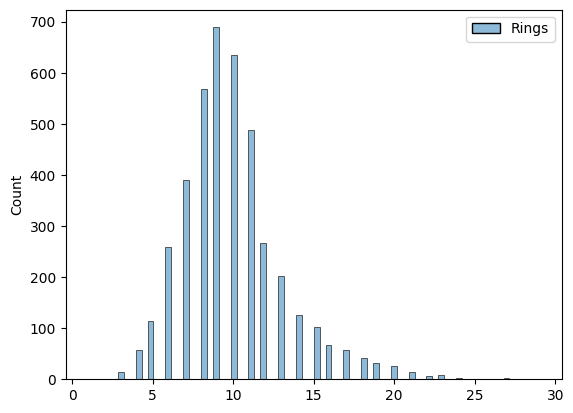

In [10]:
sns.histplot(y)

### Separando em treino  e teste

In [26]:

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y, test_size=0.3, random_state=42)


### Definindo os valores para o Grid Search

In [27]:

n_estimatores = [ i for i in range(10,121,20)]
max_depth = [4,6,8,10,None]
learning_rate = [round((1/(i)),5) for i in range(10,500,100)]

# ## 3. Definição dos Modelos e Parâmetros para Grid Search
# - Definir os parâmetros de busca para cada um dos modelos

# Definindo os parâmetros para cada modelo
param_grid_xgb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}

param_grid_lgb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}

param_grid_cat = {
    'regressor__learning_rate': learning_rate,
    'regressor__depth': max_depth,
    'regressor__iterations': n_estimatores
}

param_grid_gb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}


In [28]:

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        total_time_seconds =(datetime.now() - start_time).total_seconds()
        thour, temp_sec = divmod(total_time_seconds, 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        return total_time_seconds
    

In [30]:

xgb = TransformedTargetRegressor(XGBRFRegressor( nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

# Aplicando Grid Search para cada modelo
print("Iniciando Grid Search para XGBoost...")
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb,cv=10,scoring="neg_root_mean_squared_error" 
                               #,verbose=3
                               )

tot_time = timer()
grid_search_xgb.fit(X_train,y_train)
time_grid_search_xgb = timer(tot_time)
print(time_grid_search_xgb)

print(f"best parameter:{grid_search_xgb.best_params_} - best score:{grid_search_xgb.best_score_}")

best_xgb = grid_search_xgb.best_params_


Iniciando Grid Search para XGBoost...

 Time taken: 0 hours 3 minutes and 16.81 seconds.
196.808236
best parameter:{'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 10} - best score:-3.0467448580812464


In [31]:

lgb =TransformedTargetRegressor(LGBMRegressor(n_jobs=1,verbose=0),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_lgb = GridSearchCV(lgb, param_grid_lgb,cv=10,scoring="neg_root_mean_squared_error"
                               #,verbose=3
                               )

tot_time = timer()
grid_search_lgb.fit(X_train,y_train)
time_grid_search_lgb = timer(tot_time)
print(time_grid_search_lgb)

print(f"best parameter:{grid_search_lgb.best_params_} - best score:{grid_search_lgb.best_score_}")

best_lgb = grid_search_lgb.best_params_


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:


print("Iniciando Grid Search para CatBoost...")
cat =TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent"),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_cat = GridSearchCV(cat, param_grid_cat,cv=10,scoring="neg_root_mean_squared_error"
                               #,verbose=3
                               )

tot_time = timer()
grid_search_cat.fit(X_train,y_train)
time_grid_search_cat = timer(tot_time)
print(time_grid_search_cat)

print(f"best parameter:{grid_search_cat.best_params_} - best score:{grid_search_cat.best_score_}")

best_cat = grid_search_cat.best_params_


Iniciando Grid Search para CatBoost...

 Time taken: 0 hours 6 minutes and 28.88 seconds.
388.884109
best parameter:{'regressor__depth': 6, 'regressor__iterations': 110, 'regressor__learning_rate': 0.1} - best score:-2.142043540028765


In [33]:


print("Iniciando Grid Search para Gradient Boosting...")
gb =TransformedTargetRegressor(GradientBoostingRegressor(),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_gb = GridSearchCV(gb, param_grid_gb,cv=10,scoring="neg_root_mean_squared_error"
                              #,verbose=3
                              )

tot_time = timer()
grid_search_gb.fit(X_train,y_train)
time_grid_search_gb = timer(tot_time)
print(time_grid_search_gb)

print(f"best parameter:{grid_search_gb.best_params_} - best score:{grid_search_gb.best_score_}")

best_gb = grid_search_gb.best_params_

Iniciando Grid Search para Gradient Boosting...

 Time taken: 0 hours 14 minutes and 20.27 seconds.
860.270196
best parameter:{'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 90} - best score:-2.1430132718776176


In [34]:
best_parameters =pd.DataFrame(index=["xgb","lgb","cat","gb"],data=[best_xgb,best_lgb,best_cat,best_gb])
best_parameters.to_csv(path_or_buf=f"best_parameters_{file_prefix}.csv",sep=",")



In [35]:
time_grid_search = best_parameters =pd.DataFrame(index=["xgb","lgb","cat","gb"],data=[time_grid_search_xgb,time_grid_search_lgb,time_grid_search_cat,time_grid_search_gb])
time_grid_search.to_csv(path_or_buf=f"time_{file_prefix}.csv",sep=",")


In [36]:
best_parameters =pd.read_csv("best_parameters_cancer.csv",sep=",",index_col=[0])

best_xgb= best_parameters.loc["xgb"].dropna().to_dict()
best_lgb= best_parameters.loc["lgb"].dropna().to_dict()
best_cat= best_parameters.loc["cat"].dropna().to_dict()
best_gb= best_parameters.loc["gb"].dropna().to_dict()

best_xgb= { k: int(v) if k != "learning_rate" else v for k, v in best_xgb.items() }
best_lgb= { k: int(v) if k != "learning_rate" else v for k, v in best_lgb.items() }
best_cat= { k: int(v) if k != "learning_rate" else v for k, v in best_cat.items() }
best_gb= { k: int(v) if k != "learning_rate" else v for k, v in best_gb.items() }




In [37]:

xgb = TransformedTargetRegressor(XGBRFRegressor(**best_xgb ,nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
xgb.fit(X_train,y_train)

lgb =TransformedTargetRegressor(LGBMRegressor(n_jobs=1,verbose=0,**best_lgb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
lgb.fit(X_train,y_train)


cat =TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent",**best_cat),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
cat.fit(X_train,y_train)


gb =TransformedTargetRegressor(GradientBoostingRegressor(**best_gb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
gb.fit(X_train,y_train)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=4,
                                                               n_estimators=110),
                           transformer=MinMaxScaler())

In [38]:

# ## 5. Avaliação dos Modelos

# Função para avaliar os modelos
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("rmse", root_mean_squared_error(y_test, y_pred))
    print("mse", mean_squared_error(y_test,y_pred))
    print("r2", r2_score(y_test,y_pred))
    return y_pred

# Avaliar cada modelo
print("Avaliação do melhor modelo XGBoost")
y_pred_xgb = evaluate_model(xgb, X_test, y_test)

print("Avaliação do melhor modelo LightGBM")
y_pred_lgb = evaluate_model(lgb, X_test, y_test)

print("Avaliação do melhor modelo CatBoost")
y_pred_cat = evaluate_model(cat, X_test, y_test)

print("Avaliação do melhor modelo Gradient Boosting")
y_pred_gb = evaluate_model(gb, X_test, y_test)


Avaliação do melhor modelo XGBoost
rmse 3.04269690745929
mse 9.258004470662327
r2 0.08829069137573242
Avaliação do melhor modelo LightGBM
rmse 2.1633256759025197
mse 4.6799779800190935
r2 0.539125361047009
Avaliação do melhor modelo CatBoost
rmse 2.1632640361267064
mse 4.679711289999207
r2 0.5391516241335348
Avaliação do melhor modelo Gradient Boosting
rmse 2.210728140771448
mse 4.887318912398783
r2 0.5187068510115673


In [29]:

# ## 6. Plotar a Matriz de Confusão do Melhor Modelo

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


### Reapeated Kfold

In [39]:
cross_val_cancer_scores={}

XGBoost

In [41]:
model = TransformedTargetRegressor(XGBRFRegressor(**best_xgb ,nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)
scoring =["neg_root_mean_squared_error","neg_mean_squared_error","r2"]

cross_val_cancer_scores["xgb"] =cross_validate(model,X_encoding,y,cv=cv,scoring=scoring)

In [43]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["xgb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["xgb"]).std(axis=0))


Média
fit_time                            0.045610
score_time                          0.004031
test_neg_root_mean_squared_error   -3.074320
test_neg_mean_squared_error        -9.480774
test_r2                             0.086288
dtype: float64

Desvio Padrão
fit_time                            0.004796
score_time                          0.000893
test_neg_root_mean_squared_error    0.172127
test_neg_mean_squared_error         1.061469
test_r2                             0.006072
dtype: float64


In [52]:
model = TransformedTargetRegressor(LGBMRegressor(n_jobs=1,verbose=0,**best_lgb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)

cross_val_cancer_scores["lgb"] =cross_validate(model,X_encoding,y,cv=cv,scoring=scoring)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [53]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["lgb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["lgb"]).std(axis=0))

Média
fit_time                            0.037748
score_time                          0.004811
test_neg_root_mean_squared_error   -2.149441
test_neg_mean_squared_error        -4.632520
test_r2                             0.552093
dtype: float64

Desvio Padrão
fit_time                            0.002817
score_time                          0.002526
test_neg_root_mean_squared_error    0.112013
test_neg_mean_squared_error         0.478451
test_r2                             0.036333
dtype: float64


In [47]:
model = TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent",**best_cat),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)

cross_val_cancer_scores["cat"] =cross_validate(model,X_encoding,y,cv=cv,scoring=scoring)

In [48]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["cat"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["cat"]).std(axis=0))

Média
fit_time                            0.219340
score_time                          0.004630
test_neg_root_mean_squared_error   -2.150500
test_neg_mean_squared_error        -4.645145
test_r2                             0.552102
dtype: float64

Desvio Padrão
fit_time                            0.026401
score_time                          0.000929
test_neg_root_mean_squared_error    0.143888
test_neg_mean_squared_error         0.618781
test_r2                             0.035176
dtype: float64


In [49]:
model = TransformedTargetRegressor(GradientBoostingRegressor(**best_gb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)


cross_val_cancer_scores["gb"] =cross_validate(model,X_encoding,y,cv=cv,scoring=scoring)

In [50]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["gb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["gb"]).std(axis=0))

Média
fit_time                            0.657327
score_time                          0.003411
test_neg_root_mean_squared_error   -2.157442
test_neg_mean_squared_error        -4.672543
test_r2                             0.549576
dtype: float64

Desvio Padrão
fit_time                            0.010728
score_time                          0.000684
test_neg_root_mean_squared_error    0.134788
test_neg_mean_squared_error         0.581793
test_r2                             0.040058
dtype: float64


In [54]:
cross_val_cancer_scores

{'xgb': {'fit_time': array([0.06001329, 0.04100919, 0.04801083, 0.04399014, 0.04200959,
         0.04401112, 0.04501009, 0.04301   , 0.04300976, 0.04400802,
         0.04400969, 0.04501009, 0.04200935, 0.04601073, 0.04600978,
         0.04200912, 0.04300952, 0.04701066, 0.04500961, 0.04401016,
         0.04500985, 0.05001092, 0.08601952, 0.04901075, 0.04400969,
         0.04701018, 0.04400945, 0.04500985, 0.05101132, 0.04501009,
         0.04301   , 0.0440104 , 0.04501176, 0.04501033, 0.04400945,
         0.04501057, 0.04801011, 0.05101156, 0.04400969, 0.04300928,
         0.04300952, 0.04901123, 0.04400969, 0.04600954, 0.04400969,
         0.04200959, 0.0440104 , 0.04400992, 0.0480094 , 0.04501009,
         0.04300952, 0.04400945, 0.04400826, 0.04200888, 0.04200959,
         0.04601049, 0.04300976, 0.04601073, 0.04300952, 0.04401159,
         0.04601002, 0.04501009, 0.04501009, 0.04501009, 0.04400921,
         0.04501009, 0.04201007, 0.04300952, 0.04501128, 0.04400969,
         0.0440